# DATA620: Project 2

## Homework Team 3: David Simbandumwe, Eric Lehmphul and Lidiia Tronina

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px

## Project Objectives

1. Identify a large 2-node network dataset. (Meet the criteria tat it consists of ties between and not within two (or more) distinct groups
2. Reduce the size of te network using a method such as the island method
3. What can you infer about each of the distinct groups?

<br>

## Research Summary

This dataset was developed to support research into the network analysis of an online community. The findings were reported in a paper by Pietro Panzarasa and Tore Opsahl titled "Patterns and Dynamics of Users’ Behavior and Interaction". The research draws on longitudinal network data from an online community to examine patterns of users’ behavior and social interaction, to infer the dynamics of system usage. 

The research includes a note of caution regarding the relationship assumptions based on a weak notion of social relationship. The dataset assumes that one message is sufficient to create a relationship. This enables the inclusion of all users in the analysis but might overestimate the density of the relationship structure in the graph. 

The authors also discuss their limited ability to observe previously established offline relationships. The evolution of the network is a combination of previous offline relationships and new relationships that are developed on the platform. This analysis will likely be impacted / capture offline relationships.

And finally the lack of availability of the content of messages hampered the ability to analyze and further investigate the genuine nature of the relationships identified.

## Data Source

The dataset that we decided to use for this project is a Facebook-like Forum Network that was obtained from https://toreopsahl.com/datasets/#online_forum_network. This network does not focus on the messages exchanged between user, rather the focus is between users and topics that they partake in. The network can be weighted where the weight is based on the number of messages or characters a user has posted on a particular topic. We elected to use an edge weight that is based on messages. The two-mode network contains 899 users and 522 topics.

In [34]:
# Read in network data using num of messages for weight

# 2 mode: users and topics
weighted_2mode = pd.read_csv('http://opsahl.co.uk/tnet/datasets/OF_two-mode_weightedmsg.txt',
                            sep = ' ',
                            header = None)

weighted_2mode.columns = ["User", "Topic", "Weight"]

# update the user and topic to be unique
weighted_2mode['User'] = 'U' + weighted_2mode['User'].astype(str)
weighted_2mode['Topic'] = 'T' + weighted_2mode['Topic'].astype(str)

weighted_2mode.shape

(7089, 3)

In [76]:
u_df = weighted_2mode.groupby('User')
u_df = u_df[['User']].agg(np.size)
u_df.shape

(899, 1)

In [77]:
t_df = weighted_2mode.groupby('Topic')
t_df = t_df[['Topic']].agg(np.size)
t_df.shape

(522, 1)

First step in the analysis of the date is to review the distribution of weights. The Box plot indicates discrepancy in topic popularity. Most topics have fairly low engagement below 10 messages from the network. However there are a few topics that are incredibly popular with over 100 messages associated with those topics. 

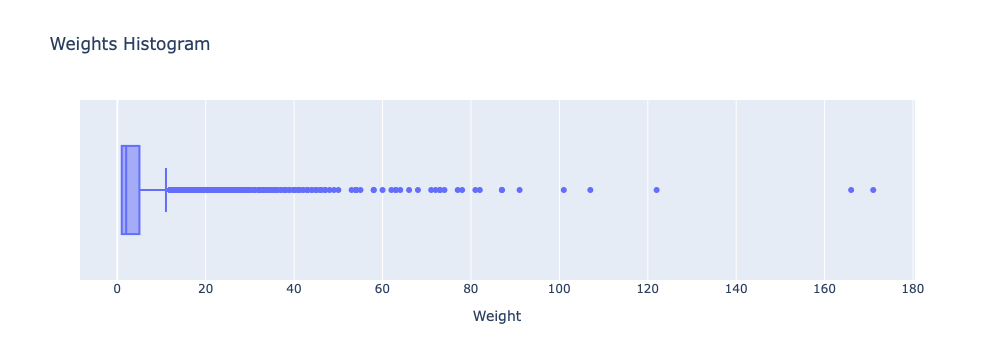

In [6]:
fig = px.box(weighted_2mode, x="Weight", hover_data=weighted_2mode.columns,
                  title="Weights Histogram")
fig.show()

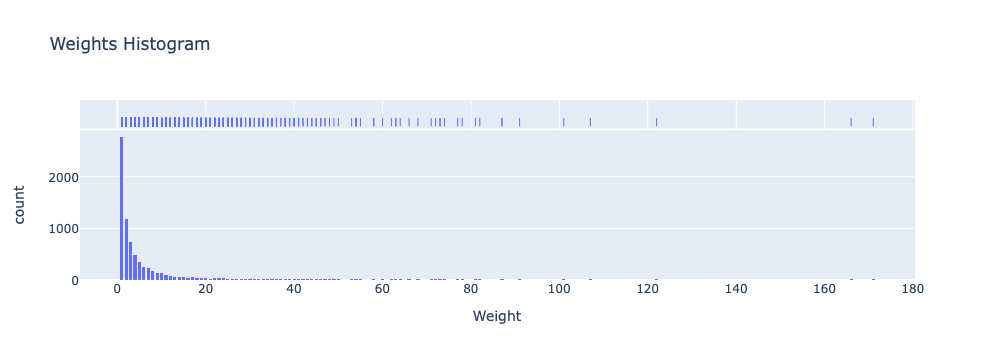

In [9]:
fig = px.histogram(weighted_2mode, x="Weight", marginal="rug",nbins=600, hover_data=weighted_2mode.columns,
                  title="Weights Histogram")
fig.show()

## Load Bipartite Graph

Using the data frame that was previously loaded we will create a Bipartite graph with both Topic and User nodes. The weights for the edges will capture the number of messages posted on a topic by the connected users.

In [281]:
# create the graph with the two node types
B = nx.Graph()
B.add_nodes_from(weighted_2mode['Topic'], bipartite=0)
B.add_nodes_from(weighted_2mode['User'], bipartite=1)

# add the weights
tuples = [tuple(x) for x in weighted_2mode.to_numpy()]
B.add_weighted_edges_from(tuples, weight='weight')

# test to see if the graph is connected
print('is the graph connected:',nx.is_connected(B))

# verify that a bipartite graph was created
print('is the graph bipartite',nx.is_bipartite(B))

# create node lists for each node type
topic_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
user_nodes = set(B) - topic_nodes

is the graph connected:  False
is the graph bipartite True


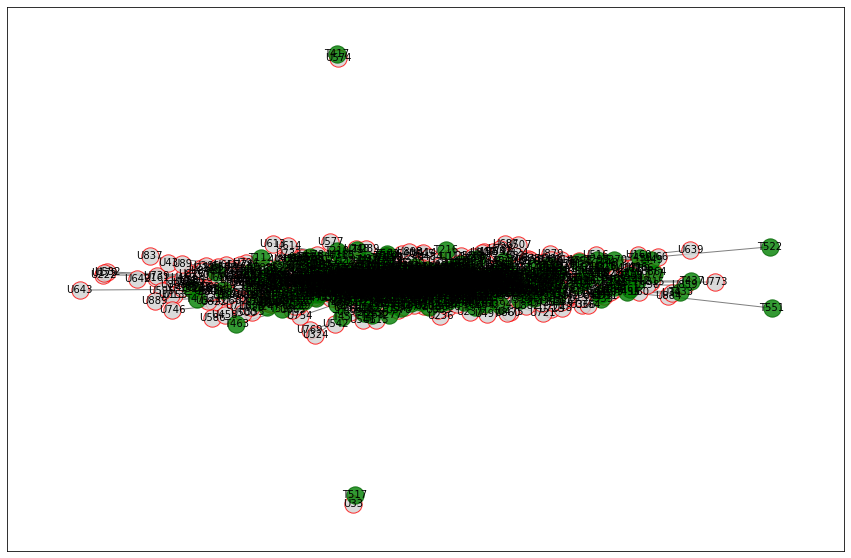

In [87]:
plt.figure(figsize = (15,10))
pos = nx.spring_layout(B)



nx.draw_networkx_nodes(B,pos,
                       nodelist=user_nodes,
                       node_color='lightgray',
                       edgecolors='red',
                       alpha=0.8)
topic = weighted_2mode['Topic']
nx.draw_networkx_nodes(B,pos,
                       nodelist=topic_nodes,
                       node_color='green',
                       edgecolors='darkgreen',
                       alpha=0.8)

nx.draw_networkx_edges(B, pos,
                       edge_color='gray',
                      )


dump = nx.draw_networkx_labels(B, pos, font_size=10)

The resulting graph is difficult to read however we can identify 1 large set of connected nodes and several smaller connected nodes.

## Filter by Popularity
We will focus on the most popular topics and the most prolific posters. We will filter out every edge with less than 40 messages. This results in a much smaller graph with 30 users and 31 topics.

In [286]:
reduced_df = weighted_2mode[weighted_2mode['Weight'] > 60]
reduced_df.shape

u_df = reduced_df.groupby('User')
u_df = u_df[['User']].agg(np.size)
u_df.shape

t_df = reduced_df.groupby('Topic')
t_df = t_df[['Topic']].agg(np.size)
t_df.shape

print('number of users:',u_df.shape[0])
print('number of topics:',t_df.shape[0])

number of users: 17
number of topics: 11


### Filter the Edges 
Using the reduced data frame to build a smaller bipartite graph. 

In [259]:
R = nx.Graph()
R.add_nodes_from(reduced_df['Topic'], bipartite=0)
R.add_nodes_from(reduced_df['User'], bipartite=1)

tuples = [tuple(x) for x in reduced_df.to_numpy()]
R.add_weighted_edges_from(tuples, weight='weight')

topic_nodes = {n for n, d in R.nodes(data=True) if d["bipartite"] == 0}
user_nodes = set(R) - topic_nodes

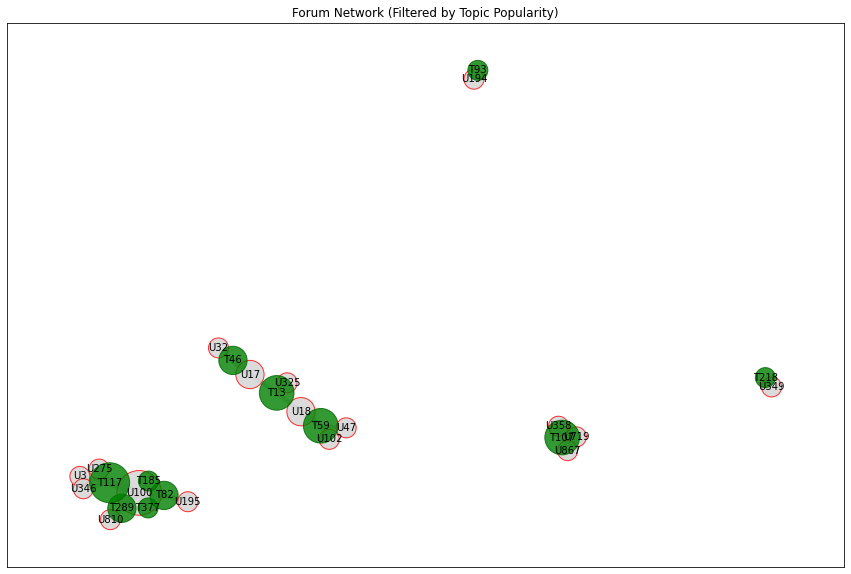

In [268]:
plt.figure(figsize = (15,10))
plt.title('Forum Network (Filtered by Topic Popularity)')

#pos = nx.random_layout(R)
pos = nx.spring_layout(R)


edge_labels = nx.get_edge_attributes(R, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.06

#edge_labels = nx.random_layout(R, 'weight')


userDegree = nx.degree(R, user_nodes) 
topicDegree = nx.degree(R, topic_nodes) 


nx.draw_networkx_nodes(R,pos,
                       nodelist=user_nodes,
                       node_color='lightgray',
                       node_size=[v * 400 for v in dict(userDegree).values()],
                       edgecolors='red',
                       
                       alpha=0.8)

#topic = weighted_2mode['Topic']
nx.draw_networkx_nodes(R,pos,
                       nodelist=topic_nodes,
                       node_color='green',
                       node_size=[v * 400 for v in dict(topicDegree).values()],
                       edgecolors='darkgreen',
                       alpha=0.8)

nx.draw_networkx_edges(R, pos,
                       edge_color='lightgray',
                       width=edge_w, 
                       #edge_color=edge_w,
                       edge_cmap=mpl.cm.Greys
                      )

dump = nx.draw_networkx_labels(R, pos, font_size=10)
#dump = nx.draw_networkx_edge_labels(R, pos=pos,edge_labels=edge_labels)
plt.show()

The resulting graph highlights even in this reduced set there are still some very popular topics and prolific users.

### Sub Graph Ego Network
Center the subgraph on the U100 node we can see the resulting ego network

In [275]:
#EN = nx.ego_graph(B,'U100', radius=2)
EN = nx.ego_graph(B,'U882', radius=3)

In [276]:
len(EN)

168

The averg clustering score of 0 suggests that this is a broadcaster

In [277]:
nx.average_clustering(EN)

0.0

In [278]:
userDegree = nx.degree(EN, user_nodes) 
topicDegree = nx.degree(EN, topic_nodes) 

In [279]:
edge_labels = nx.get_edge_attributes(EN, 'weight')

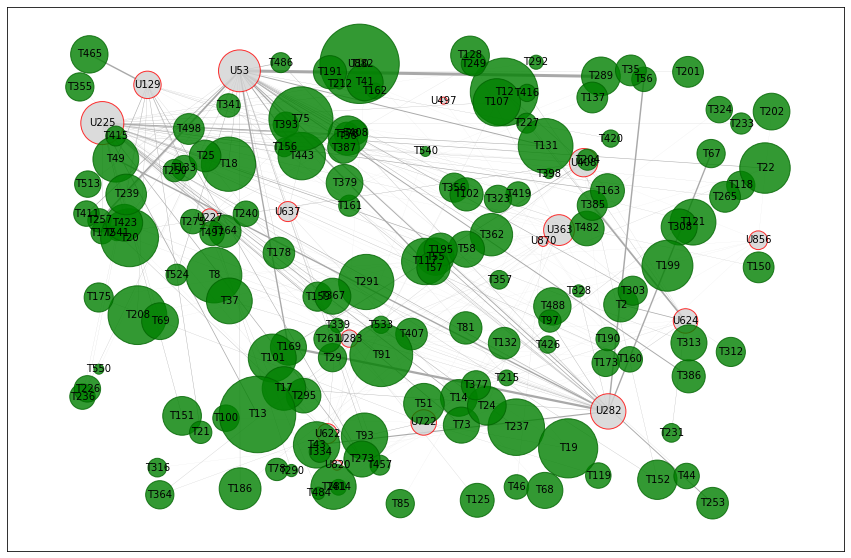

In [280]:
plt.figure(figsize = (15,10))
pos = nx.random_layout(EN)
edge_labels = nx.get_edge_attributes(EN, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.05
#pos = nx.kamada_kawai_layout(R)
#edge_labels = nx.random_layout(R, 'weight')

topic_nodes = {n for n, d in EN.nodes(data=True) if d["bipartite"] == 0}
user_nodes = set(EN) - topic_nodes

userDegree = nx.degree(B, user_nodes) 
topicDegree = nx.degree(B, topic_nodes) 


nx.draw_networkx_nodes(EN,pos,
                       nodelist=user_nodes,
                       node_color='lightgray',
                       node_size=[v * 50 for v in dict(userDegree).values()],
                       edgecolors='red',
                       alpha=0.8)

nx.draw_networkx_nodes(EN,pos,
                       nodelist=topic_nodes,
                       node_color='green',
                       node_size=[v * 50 for v in dict(topicDegree).values()],
                       edgecolors='darkgreen',
                       alpha=0.8)

nx.draw_networkx_edges(EN, pos,
                       #edge_color='gray',
                       width=edge_w, 
                       #edge_color=edge_w,
                       edge_color='darkgray',
                       edge_cmap=mpl.cm.Greys
                      )

dump = nx.draw_networkx_labels(EN, pos, font_size=10)


## Scale-free network
The research paper suggests that this is an example of a scale free network. Some of the characteristicss of scale free network include:

* review the distribution of degree calculatiosn across both nodes
* use the powers law package to analysis the consistency between this network and the fit

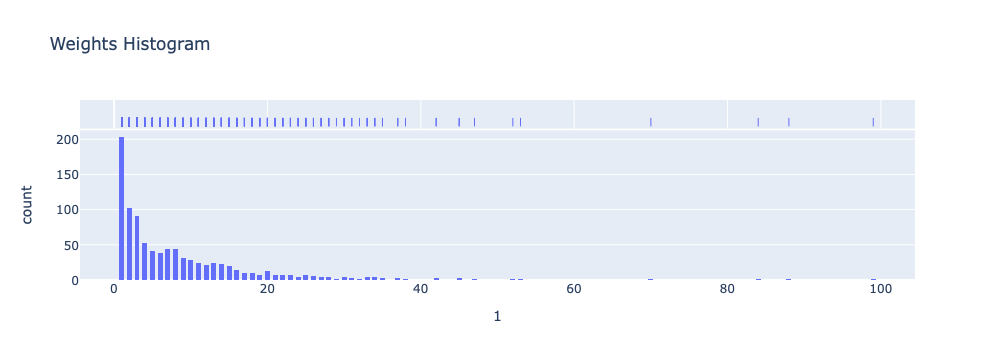

In [21]:
userDegree = nx.degree(B, user_nodes) 
pd.DataFrame(userDegree)
fig = px.histogram(pd.DataFrame(userDegree), x=1, marginal="rug",nbins=200,title="Weights Histogram")
fig.show()

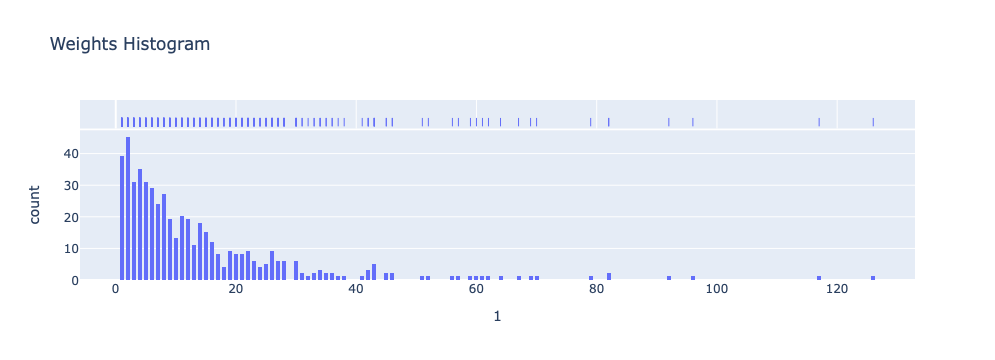

In [22]:
topicDegree = nx.degree(B, topic_nodes) 
pd.DataFrame(userDegree)
fig = px.histogram(pd.DataFrame(topicDegree), x=1, marginal="rug",nbins=280,title="Weights Histogram")
fig.show()

In [23]:
import powerlaw

degree_sequence = sorted([d for n, d in B.degree()], reverse=True) # used for degree distribution and powerlaw test
fit = powerlaw.Fit(degree_sequence) 

Calculating best minimal value for power law fit


<AxesSubplot:>

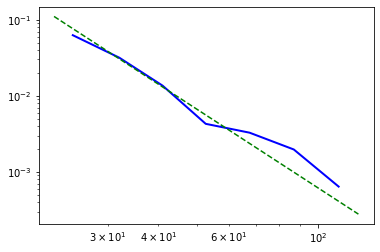

In [24]:
fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)

In [25]:
R, p = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print (R, p)

2.0976234503135034 0.035938421879085504


<AxesSubplot:>

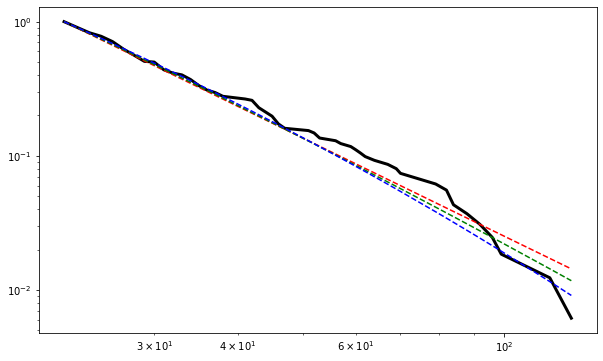

In [26]:
plt.figure(figsize=(10, 6))
fit.distribution_compare('power_law', 'lognormal')
fig4 = fit.plot_ccdf(linewidth=3, color='black')
fit.power_law.plot_ccdf(ax=fig4, color='r', linestyle='--') #powerlaw
fit.lognormal.plot_ccdf(ax=fig4, color='g', linestyle='--') #lognormal
fit.stretched_exponential.plot_ccdf(ax=fig4, color='b', linestyle='--') #stretched_exponential

In [ ]:
From these calculations that results seem incluslive about if this conforms to the powers law. 




## One Mode Projection - Users
Projection is used to analyze the centrality measures for the Forum Network network. We will use degree, closeness, betweenes and eigenvectors centrality measures to assess the relative importance of each User node to the network

* First, we will project the graph onto the User node
* Calculate degree, closeness, betweenness and eigenvectors centrality for the graph
* Identify the nodes with higher centrality measures

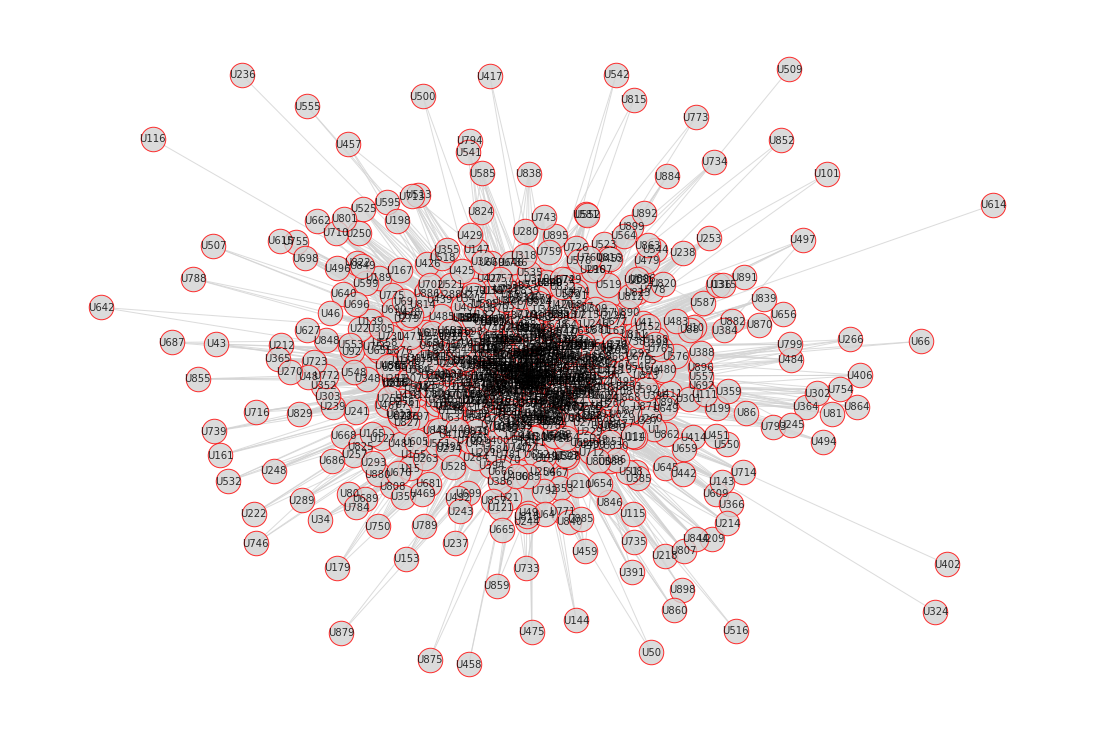

In [220]:
# User subgraph
plt.figure(figsize = (15,10))
# project graph
U = bipartite.weighted_projected_graph(B, user_nodes)


pos_U = nx.spring_layout(U)



weights_U = [edata['weight'] for f,t,edata in U.edges(data=True)]

nx.draw(U, 
        pos = pos_U, 
        with_labels=True, 
        node_color='lightgray',
        edgecolors='red',
        edge_color='lightgray',
        font_color='black', 
        node_size = 600,
        font_size=10,
        alpha=0.8)



### Measures of Centrality

In [191]:
# calculate measures of centrality
deg = nx.degree(U)
c = nx.closeness_centrality(U)
b=nx.betweenness_centrality(U)
e = nx.eigenvector_centrality(U, max_iter=100) 

df = pd.DataFrame(user_nodes, columns=['User'])

df['Degree'] = df['User'].map(dict(deg))
df['Closeness'] = df['User'].map(dict(c))
df['Betweenness'] = df['User'].map(dict(b))
df['Eigenvector'] = df['User'].map(dict(e))

In [200]:
df[df['Degree'] >= 0].sort_values('Degree',ascending=False, inplace=False).round(decimals=4)

User  Degree  Closeness  Betweenness  Eigenvector
60   U100     633     0.7784       0.0343       0.0962
178   U67     604     0.7590       0.0270       0.0941
135  U377     565     0.7338       0.0164       0.0909
106  U164     563     0.7332       0.0257       0.0897
40   U319     546     0.7230       0.0114       0.0907
..    ...     ...        ...          ...          ...
261   U21      20     0.4831       0.0000       0.0049
262    U8      19     0.4715       0.0000       0.0039
130  U699      18     0.4728       0.0000       0.0044
195  U882      16     0.4495       0.0000       0.0026
203  U237       8     0.4555       0.0000       0.0020

[281 rows x 5 columns]

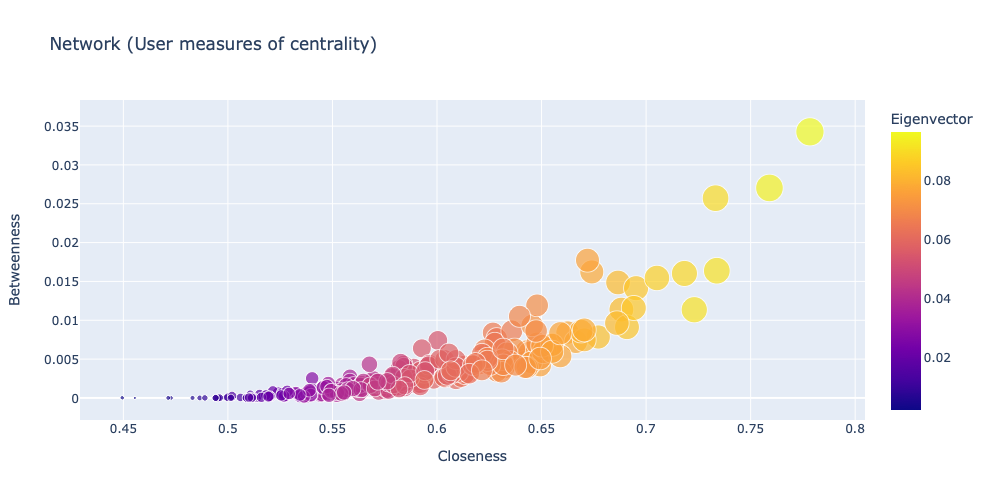

In [201]:
fig = px.scatter(df, x="Closeness", y="Betweenness", size="Degree", color="Eigenvector", 
                    hover_name="User", width=800, height=500, title="Network (User measures of centrality)")
fig.show()

### User Graph Reduction

In [169]:
# method to trim graph by edge weights
def trim_edges(g, weight=1):
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,**edata)
    return g2 

 
# function to find islands
def island_method(g, iterations=5):
    
    weights=[edata['weight'] for f,to,edata in g.edges(data=True)]
 
    mn=int(min(weights))
    mx=int(max(weights))

    step=int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)] 

In [170]:
# retrieve the connected graphs
S = [U.subgraph(c).copy() for c in nx.connected_components(U)][0]
islands=island_method(S)

# create dataframe for results
island_df = pd.DataFrame(columns=['threshold','nodes','islands'])

# add the results of each iteration to the dataframe
for i,r in enumerate(islands):
    island_df.loc[i] = [r[0],len(r[1]),len(list(nx.connected_components(r[1])))]
    
    
island_df  


threshold  nodes  islands
0          1    640        1
1          7    110        1
2         13     33        3
3         19      9        1
4         25      4        1

In [207]:
# variable for the target weight
filter_weight = 13        
filter_U = trim_edges(U,filter_weight)        
        
# add the edge attributes        
edge_labels = nx.get_edge_attributes(filter_U, 'weight')
edge_w = np.array(list(edge_labels.values())) * 0.3

# generate the weighted data
weights=[edata['weight'] for f,t,edata in filter_U.edges(data=True)]

# calculate the degree
userDegree = nx.degree(filter_U) 

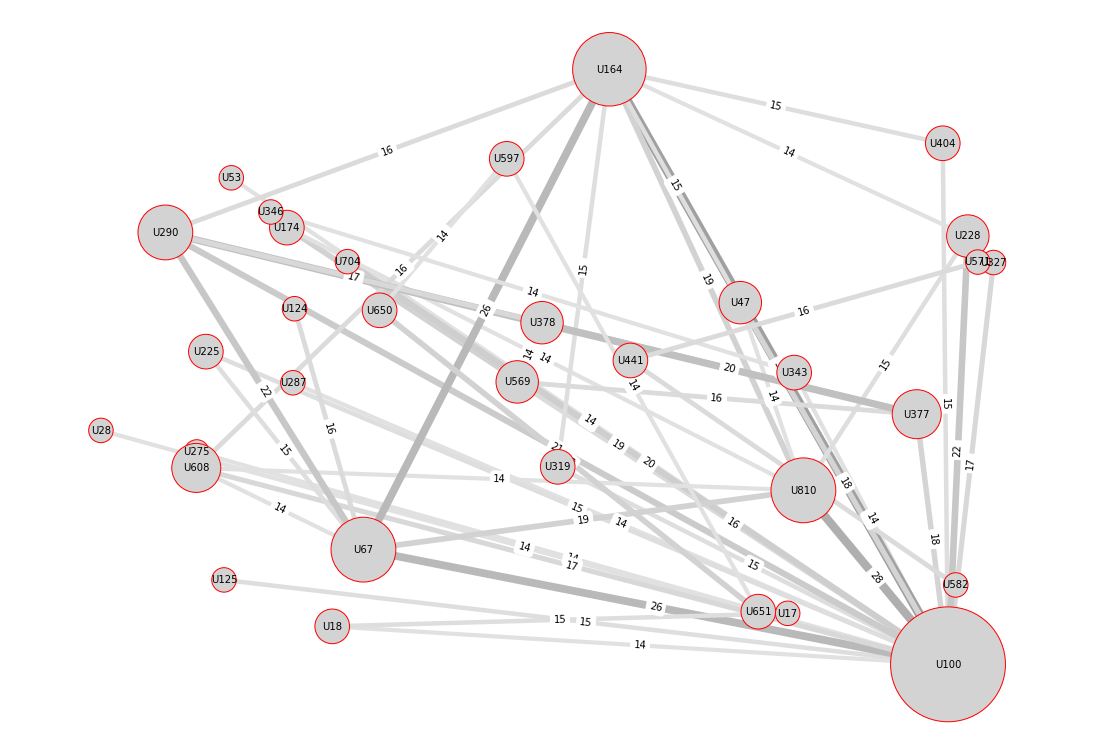

In [208]:
plt.figure(figsize = (15,10))
pos_U = nx.random_layout(filter_U)


# plot the resulting filtered graph
nx.draw(filter_U, 
        pos=pos_U, 
        with_labels=True, 
        node_size = [v * 600 for v in dict(userDegree).values()], 
        node_color='lightgray', 
        edgecolors='red',
        font_color='black', 
        font_size=10,
        edge_cmap=mpl.cm.Greys, 
        width=edge_w, 
        edge_color=edge_w,
        edge_vmin=0, edge_vmax=20)

dump = nx.draw_networkx_edge_labels(filter_U, pos=pos_U,edge_labels=edge_labels)

## One Mode Projection - Topics

Projection is used to analyze the centrality measures for the Forum Network. We will use degree, closeness, betweenes and eigenvectors centrality measures to assess the relative importance of each Topic node to the network

* First, we will project the graph onto the Topic node
* Calculate degree, closeness, betweenness and eigenvectors centrality for the graph
* Identify the nodes with higher centrality measures


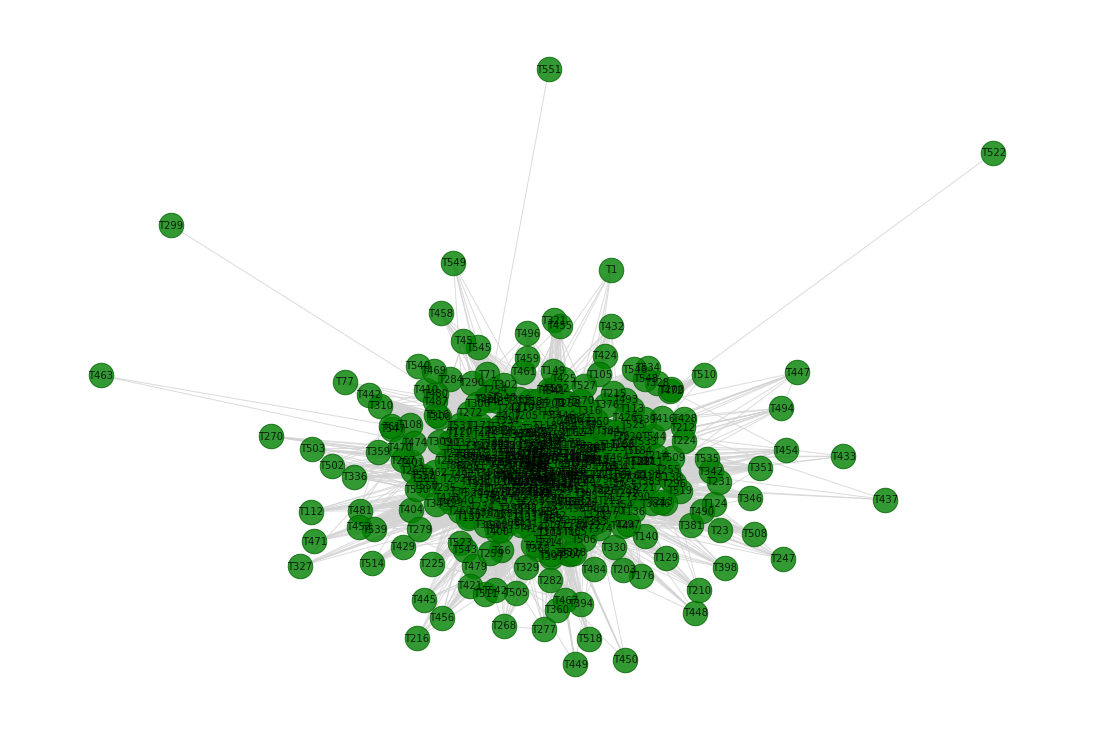

In [230]:
# topic subgraph
plt.figure(figsize = (15,10))
# project graph
T = bipartite.weighted_projected_graph(B, topic_nodes)

pos_T = nx.spring_layout(T)
weights_T = [edata['weight'] for f,t,edata in U.edges(data=True)]

nx.draw(T, pos = pos_T, 
        with_labels=True, 
        node_color='green',
        node_size = 600,
        font_color='black', 
        edgecolors='darkgreen',
        edge_color='lightgray',
        font_size=10,
        alpha=0.8)



### Measures of Centrality

In [221]:
# calculate measures of centrality
deg = nx.degree(T)
c = nx.closeness_centrality(T)
b=nx.betweenness_centrality(T)
e = nx.eigenvector_centrality(T, max_iter=100) 

df = pd.DataFrame(topic_nodes, columns=['Topic'])

df['Degree'] = df['Topic'].map(dict(deg))
df['Closeness'] = df['Topic'].map(dict(c))
df['Betweenness'] = df['Topic'].map(dict(b))
df['Eigenvector'] = df['Topic'].map(dict(e))

In [222]:
df[df['Degree'] >= 0].sort_values('Degree',ascending=False, inplace=False).round(decimals=4)

Topic  Degree  Closeness  Betweenness  Eigenvector
53    T13     410     0.8251       0.0199       0.0900
372   T12     403     0.8173       0.0159       0.0898
263   T82     397     0.8097       0.0182       0.0880
352  T237     394     0.8034       0.0112       0.0899
295  T208     390     0.7997       0.0113       0.0892
..    ...     ...        ...          ...          ...
43   T447      10     0.4655       0.0000       0.0021
109  T247      10     0.4878       0.0000       0.0026
276  T216       7     0.4533       0.0000       0.0020
286  T270       7     0.4864       0.0000       0.0027
224  T437       4     0.4651       0.0000       0.0013

[479 rows x 5 columns]

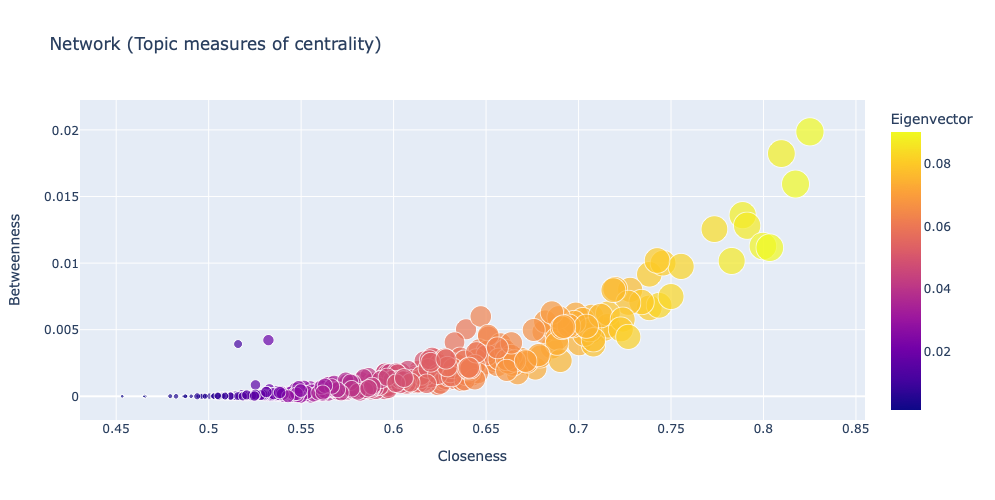

In [224]:
fig = px.scatter(df, x="Closeness", y="Betweenness", size="Degree", color="Eigenvector", 
                    hover_name="Topic", width=800, height=500, title="Network (Topic measures of centrality)")
fig.show()

### Topic Graph Reduction

In [225]:
# retrieve the connected graphs
S2 = [T.subgraph(c).copy() for c in nx.connected_components(T)][0]
islands2=island_method(S2)

# create dataframe for results
island_df2 = pd.DataFrame(columns=['threshold','nodes','islands'])

# add the results of each iteration to the dataframe
for i,r in enumerate(islands2):
    island_df2.loc[i] = [r[0],len(r[1]),len(list(nx.connected_components(r[1])))]
    
       
island_df2 
#len(islands)

threshold  nodes  islands
0          1    462        1
1          8    101        2
2         15     32        2
3         22     13        1
4         29      6        3
5         36      2        1

In [243]:
# variable for the target weight
filter_weight = 8       
        
filter_T = trim_edges(T,filter_weight)        
        
# add the edge attributes        
edge_labels2 = nx.get_edge_attributes(filter_T, 'weight')
edge_w = np.array(list(edge_labels2.values())) * 0.4

# generate the weighted data
weights=[edata['weight'] for f,t,edata in U.edges(data=True)]

# calculate the degree
topicDegree = nx.degree(filter_T) 

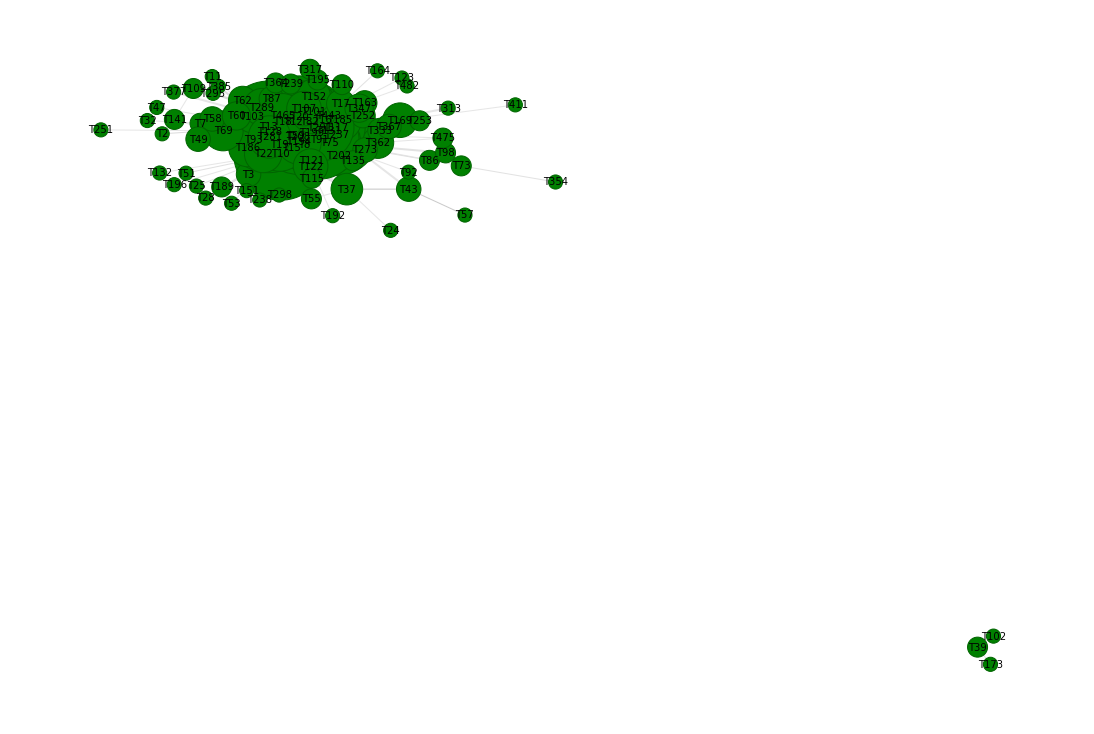

In [247]:
pos_T = nx.spring_layout(filter_T)
#pos_T = nx.random_layout(filter_T)


# plot the resulting filtered graph
plt.figure(figsize = (15,10))
nx.draw(filter_T, 
        pos=pos_T, 
        with_labels=True, 
        node_size = [v * 200 for v in dict(topicDegree).values()], 
        node_color='green', 
        edgecolors='darkgreen',
        font_color='black', 
        font_size=10,
        width=weights,
        edge_color=edge_w,
        edge_cmap=mpl.cm.Greys,
        edge_vmin=0, edge_vmax=20)

#dump = nx.draw_networkx_edge_labels(filter_T, pos=pos_T,edge_labels=edge_labels2)

# Conclusion

The findings from Panzarasa and Opsahl concluded that:

* the Forum Network exhibits “scale-free” behavior. 
* User differ in popularity and gregariousness
* User have a tendency to forge strong ties and develop socially cohesive local environments.

The findings on the “scale-free” behavior of the system have implications for information diffusion and the robustness of the system. Although we were unable to recreate the analysis that generated these findings we can see the elements of information diffusion and robustness throughout the analysis. 

If we look at the Ego network for the least connected User. We still see interaction with x Topics and x Users at 3 degrees. The denseness of the network suggests that the network would be resilient to the removal of a single hub. 